In [5]:
import pickle
import numpy as np
# Define the file path
file_path = "qqp5000w2v.pkl"
w2vResult = None
# Read the list from the binary file using pickle
with open(file_path, "rb") as file:
    w2vResult = pickle.load(file)



file_path = "qqp5000bm25P.pkl"
bm25Result = None
# Read the list from the binary file using pickle
with open(file_path, "rb") as file:
    bm25Result = pickle.load(file)

'''
file_path = "qqp5000labels.pkl"
labels = None
# Read the list from the binary file using pickle
with open(file_path, "rb") as file:
    labels = pickle.load(file)
'''
file_path = "qqp5000TinyBert.pkl"
tinyBertResult = None
# Read the list from the binary file using pickle
with open(file_path, "rb") as file:
    tinyBertResult = pickle.load(file)

file_path = "qqpTestRoBertLarge.pkl"
largeBertResult = None
# Read the list from the binary file using pickle
with open(file_path, "rb") as file:
    largeBertResult = pickle.load(file)


file_path = "qqp5000DistilBertBase.pkl"
distilBertResult = None
# Read the list from the binary file using pickle
with open(file_path, "rb") as file:
    distilBertResult = pickle.load(file)

In [6]:
#'''
def trim(originSize, newSize, originList):
    newList = originList[:newSize*originSize]
    retList = []
    for idx in range(0,len(newList),originSize):
        retList += newList[idx:idx+newSize]
    return retList
bm25Result = trim(5000,3000, bm25Result)
w2vResult = trim(5000,3000, w2vResult)
tinyBertResult = trim(5000,3000, tinyBertResult)
distilBertResult = trim(5000,3000, distilBertResult)


def diag(size,resultList):
    retList = []
    for idx in range(size):
        retList.append(resultList[idx * size + idx])
    return retList

tinyBertResultDiag = diag(3000,tinyBertResult)
bm25ResultDiag = diag(3000,bm25Result)
w2vResultDiag = diag(3000,w2vResult)
distilBertResultDiag = diag(3000,distilBertResult)

#'''

In [14]:
def measure(result,threshold):
    counter = 0
    negCounter = 0
    totalDuplicatePredicted = 0
    totalScore = 0
    #threshold = -2 #0.1   -2
    for r in result:
        if r[0] >= threshold and r[1] == 1:
            counter += 1
        if r[0] < threshold and r[1] == 0:
            negCounter += 1
        if r[0] >= threshold:
            totalDuplicatePredicted += 1
        totalScore += r[0]
    if totalDuplicatePredicted == 0:
        return 0., negCounter/(len(result)-totalDuplicatePredicted),(counter+negCounter)/len(result)
    if totalDuplicatePredicted == len(result):
        return counter/totalDuplicatePredicted, 0.,(counter+negCounter)/len(result)
    return counter/totalDuplicatePredicted, negCounter/(len(result)-totalDuplicatePredicted),(counter+negCounter)/len(result)

In [15]:
from functools import cmp_to_key

def compareTuple(a,b):
    return a[0] - b[0]

def intervalMeasure(result, scoreList):
    result = sorted(result,key = cmp_to_key(compareTuple))
    resultIdx = 0
    ret = []
    while result[resultIdx][0] < scoreList[0] - (scoreList[1] - scoreList[0]): #so the first interval won't be zero
        resultIdx += 1
    for idx, score in enumerate(scoreList):
        
        curPos = 0
        curTotal = 0
        while resultIdx < len(result) and result[resultIdx][0] < score:
            if result[resultIdx][1] == 1:
                curPos += 1
            curTotal += 1
            resultIdx += 1
        if curTotal == 0:
                ret.append(0.0)
                continue
        ret.append(curPos/curTotal)
    
    return ret


In [40]:
# get top n matches from bm25 (score, label, index)
def preRetrieval(bm25Result,size, topn):
    bm25Result = [(bm25Result[i][0],bm25Result[i][1],i) for i in range(len(bm25Result))]
    retList = [[] for _ in range(topn)]
    for idx in range(0,len(bm25Result),size):
        highist = sorted(bm25Result[idx:idx+size])
        retList[0].append(highist[-1])
        batchNum = 0
        for i in range(len(highist)-2,-1,-1):
            if highist[i][0] < highist[i+1][0]:
                batchNum+=1
                if batchNum >= topn:
                    break
                else:
                    retList[batchNum].append(highist[i])
            else:
                retList[batchNum].append(highist[i])
    return retList
distilBertFiltered = preRetrieval(bm25Result,3000,5)

In [49]:
''' # total pos pair in data, 1180 for 3k*3k
counter = 0
for r in distilBertResult:
    if r[1] == 1:
        counter +=1
print(counter)
'''
# tp, and percentage positive retrieved
totalcounter = 0
for i in range(5):
    counter = 0
    print(str(i) + " batch")
    for j in distilBertFiltered[i]:
        if j[1] == 1:
            counter += 1
            totalcounter += 1
    print(counter / len(distilBertFiltered[i]))
    print(totalcounter /1180)

0 batch
0.19084604715672676
0.5830508474576271
1 batch
0.018323474246140527
0.690677966101695
2 batch
0.016036381043561514
0.747457627118644
3 batch
0.009551310528653932
0.7838983050847458
4 batch
0.006997455470737914
0.811864406779661


In [338]:
# high = first batch, mid = batch 2-4
import random
def getTrueMean(l):
    trueMean = 0
    for r in l:
        if r[1] == 1:
            trueMean += 1
    trueMean /= len(l)
    return trueMean

tinyBertHigh = []
for r in distilBertFiltered[0]:
    tinyBertHigh.append(tinyBertResult[r[2]] + (r[2],))
tinyBertHighWeight = [w[0] for w in tinyBertHigh]
highTrueSumWeight = sum(tinyBertHighWeight)
highTrueMean = getTrueMean(tinyBertHigh)

tinyBertMid  = []
for r in distilBertFiltered[1]:
    tinyBertMid.append(tinyBertResult[r[2]] + (r[2],))
for r in distilBertFiltered[2]:
    tinyBertMid.append(tinyBertResult[r[2]] + (r[2],))
for r in distilBertFiltered[3]:
    tinyBertMid.append(tinyBertResult[r[2]] + (r[2],))
tinyBertMidWeight = [w[0] for w in tinyBertMid]
midTrueSumWeight = sum(tinyBertMidWeight)
midTrueMean = getTrueMean(tinyBertMid)


In [392]:

numTrail = 1000
sampleSize = 100

result = []
for _ in range(numTrail):
    highSample = random.choices(tinyBertHigh, weights=tinyBertHighWeight,k=sampleSize)
    mean = 0
    for s in highSample:
        if s[1] == 1:
            mean += highTrueSumWeight / (len(tinyBertHigh) * s[0])
    mean /= sampleSize
    result.append(100*(mean - highTrueMean))
#print(result)
print(np.var(result))
print(np.mean(result))
#print(highTrueMean)


13.454182409677443
0.15736392890094694


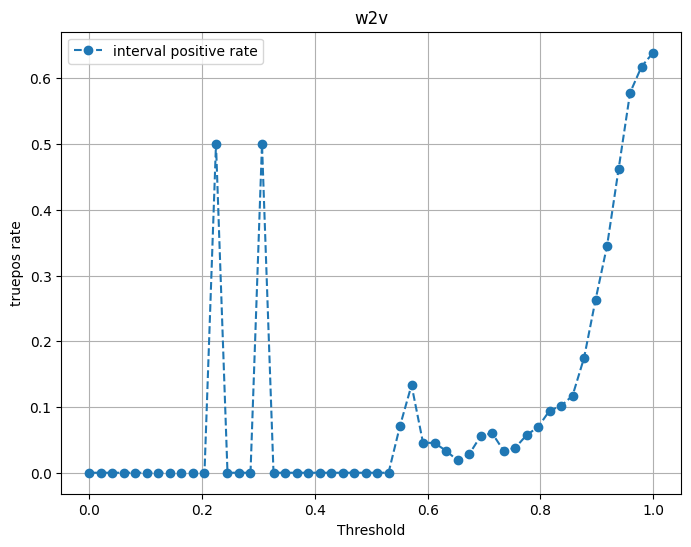

In [9]:
import numpy as np
import matplotlib.pyplot as plt
bm25Axis = np.linspace(0.0,1.0,50).tolist()
bm25IntervalPos = intervalMeasure(w2vResult,bm25Axis)

x_values = bm25Axis  # X-axis values
# Create the line graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

plt.plot(x_values, bm25IntervalPos, label='interval positive rate', marker='o', linestyle='--')

# Add labels and a legend
plt.xlabel('Threshold')
plt.ylabel('truepos rate')
plt.title('w2v')
plt.legend()

# Show the graph (or save it to a file with plt.savefig)
plt.grid(True)  # Optional: Show grid lines
plt.show()

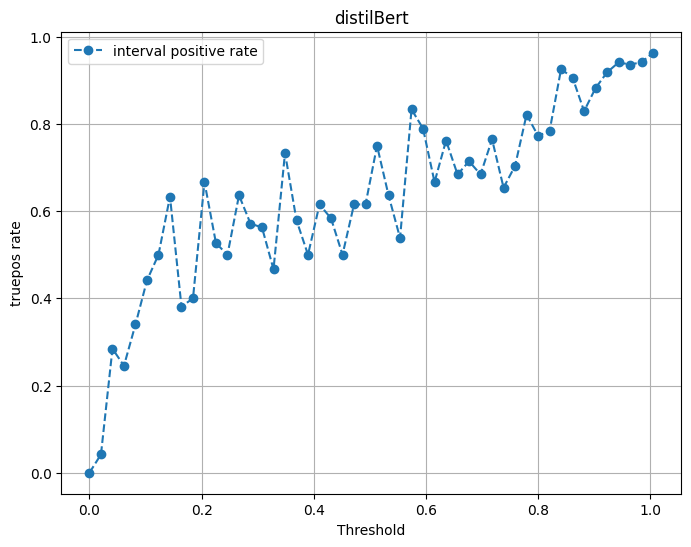

In [118]:
import numpy as np
import matplotlib.pyplot as plt
bm25Axis = np.linspace(0.0,1.005,50).tolist()
bm25IntervalPos = intervalMeasure(distilBertResultDiag,bm25Axis)

x_values = bm25Axis  # X-axis values
# Create the line graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

plt.plot(x_values, bm25IntervalPos, label='interval positive rate', marker='o', linestyle='--')

# Add labels and a legend
plt.xlabel('Threshold')
plt.ylabel('truepos rate')
plt.title('distilBert')
plt.legend()

# Show the graph (or save it to a file with plt.savefig)
plt.grid(True)  # Optional: Show grid lines
plt.show()

In [18]:
filteredDistilBertResult = []
for idx,r in enumerate(distilBertResult):
    if idx in preRetrievalResult:
        filteredDistilBertResult.append(r)

counter = 0
for r in filteredDistilBertResult:
    if r[1] == 1:
        counter += 1
print(counter / len(filteredDistilBertResult))

counter = 0
for r in distilBertResultDiag:
    if r[1] == 1:
        counter +=  1
print(counter / len(distilBertResultDiag))

0.1952326901248581
0.3933333333333333


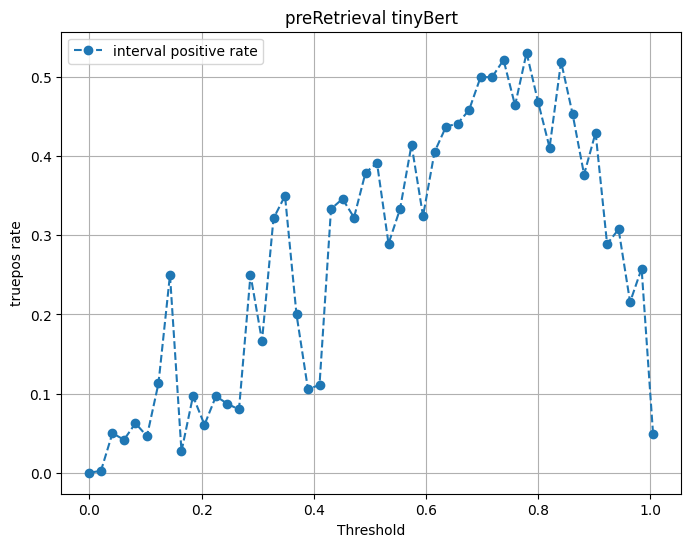

In [202]:
import numpy as np
import matplotlib.pyplot as plt

bm25Axis = np.linspace(0.0,1.005,50).tolist()
bm25IntervalPos = intervalMeasure(tinyBertHigh, bm25Axis)

x_values = bm25Axis  # X-axis values
# Create the line graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

plt.plot(x_values, bm25IntervalPos, label='interval positive rate', marker='o', linestyle='--')

# Add labels and a legend
plt.xlabel('Threshold')
plt.ylabel('truepos rate')
plt.title('preRetrieval tinyBert')
plt.legend()

# Show the graph (or save it to a file with plt.savefig)
plt.grid(True)  # Optional: Show grid lines
plt.show()

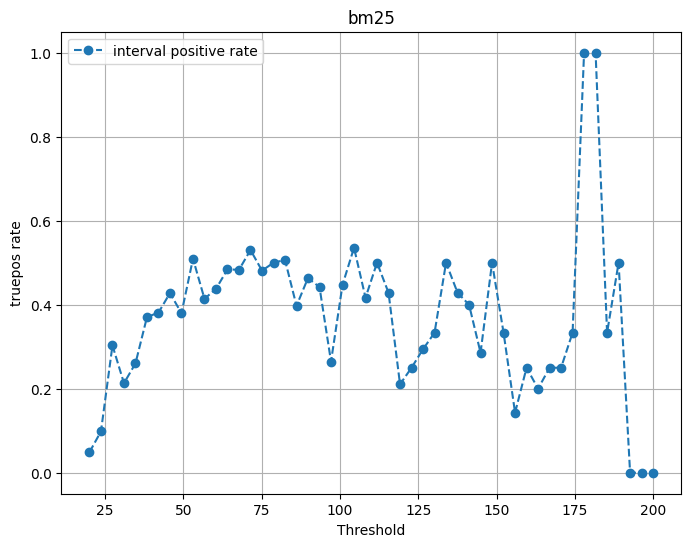

In [25]:
import numpy as np
import matplotlib.pyplot as plt
bm25Axis = np.linspace(20,200,50).tolist()
bm25IntervalPos = intervalMeasure(bm25ResultDiag,bm25Axis)

x_values = bm25Axis  # X-axis values
# Create the line graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

plt.plot(x_values, bm25IntervalPos, label='interval positive rate', marker='o', linestyle='--')

# Add labels and a legend
plt.xlabel('Threshold')
plt.ylabel('truepos rate')
plt.title('bm25')
plt.legend()

# Show the graph (or save it to a file with plt.savefig)
plt.grid(True)  # Optional: Show grid lines
plt.show()

In [36]:
counter = 0
for r in w2vResultDiag:
    if r[0] > 0.95:
        counter += 1
print(counter)

812


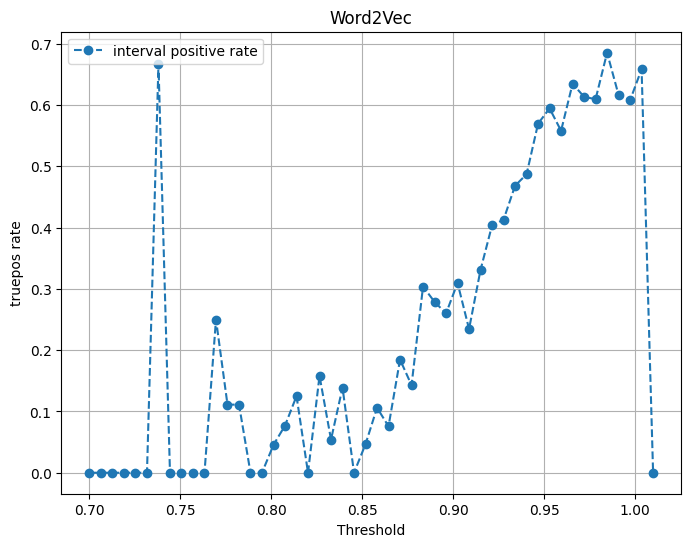

In [29]:
import numpy as np
import matplotlib.pyplot as plt
w2vxAxis = np.linspace(0.7,1.01,50).tolist()
w2vIntervalPos = intervalMeasure(w2vResultDiag,w2vxAxis)

x_values = w2vxAxis  # X-axis values
# Create the line graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

plt.plot(x_values, w2vIntervalPos, label='interval positive rate', marker='o', linestyle='--')

# Add labels and a legend
plt.xlabel('Threshold')
plt.ylabel('truepos rate')
plt.title('Word2Vec')
plt.legend()

# Show the graph (or save it to a file with plt.savefig)
plt.grid(True)  # Optional: Show grid lines
plt.show()

0.9998688888888889


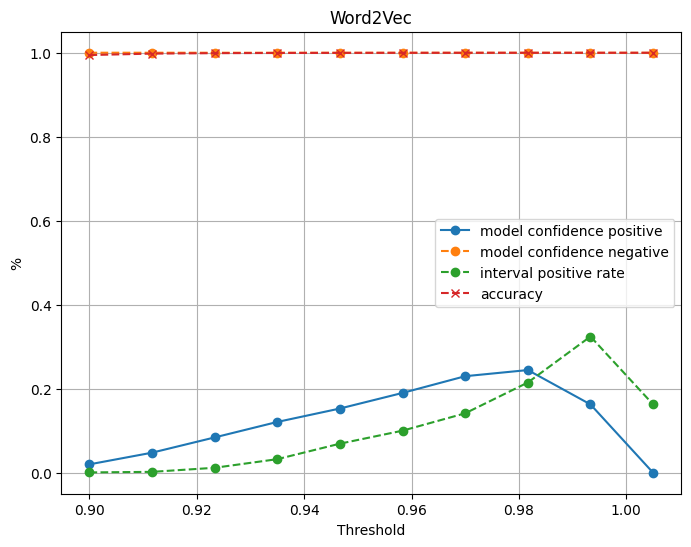

In [95]:
#'''
import numpy as np
import matplotlib.pyplot as plt

w2vxAxis = np.linspace(0.90,1.005,10).tolist()
w2vtruePos = []
w2vtrueNeg = []
w2vAccuracy = []
w2vIntervalPos = intervalMeasure(w2vResult,w2vxAxis)
for threshold in w2vxAxis:
    tp,tn,ac = measure(w2vResult,threshold)
    w2vtruePos.append(tp)
    w2vtrueNeg.append(tn)
    w2vAccuracy.append(ac)

print(max(w2vAccuracy))
# Sample data
x_values = w2vxAxis  # X-axis values
y1_values = w2vtruePos  # First set of Y-axis values
y2_values = w2vtrueNeg  # Second set of Y-axis values

# Create the line graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(x_values, y1_values, label='model confidence positive', marker='o', linestyle='-')
plt.plot(x_values, y2_values, label='model confidence negative', marker='o', linestyle='--')
plt.plot(x_values, w2vIntervalPos, label='interval positive rate', marker='o', linestyle='--')
plt.plot(x_values, w2vAccuracy, label='accuracy', marker='x', linestyle='--')

# Add labels and a legend
plt.xlabel('Threshold')
plt.ylabel('%')
plt.title('Word2Vec')
plt.legend()

# Show the graph (or save it to a file with plt.savefig)
plt.grid(True)  # Optional: Show grid lines
plt.show()
#'''

In [51]:
w2vResult.sort(reverse=True)

In [171]:
cutOffacc = w2vxAxis[0] - (w2vxAxis[1]-w2vxAxis[0])
cutOffList = []
for result in w2vResult:
    if result[0] > cutOffacc:
        cutOffList.append(result)
        continue
    break
weight = []
curWeightIdx = 0
cutOffList.reverse()
for c in cutOffList:
    while c[0] >= w2vxAxis[curWeightIdx]:
        curWeightIdx += 1
        #print(curWeightIdx)
    weight.append(w2vIntervalPos[curWeightIdx])
print(len(cutOffList))

2333


In [417]:
import random
expectation = 0
sumWeight = sum(weight)
for idx in range(len(cutOffList)):
    expectation += weight[idx] * weight[idx] / sumWeight

print(expectation)
#print(f"Mean: {mean_value}")
#print(f"Variance: {variance_value}")



0.39258068144204


In [ ]:
''' #cutoff
numSampleList = [1,5,10,50,100,500,1000]
varianceList = []
for numSample in numSampleList:
    sampleResult = []
    numTrail = 1000
    for i in range(numTrail):
        sample = random.choices(cutOffList,weight,k=numSample)
        posCount = 0
        for s in sample:
            if s[1] == 1:
                posCount += 1
        sampleResult.append(posCount/ len(sample) - expectation)



    mean_value = np.mean(sampleResult)
    print(mean_value)

    # Calculate the variance
    variance_value = np.var(sampleResult)
    varianceList.append(variance_value)

# Create the line graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

plt.plot(numSampleList, varianceList, label='variance', marker='o', linestyle='--')
plt.yscale('log')
# Add labels and a legend
plt.xlabel('sample size')
plt.ylabel('variance')
plt.title('Word2Vec')
plt.legend()

# Show the graph (or save it to a file with plt.savefig)
plt.grid(True)  # Optional: Show grid lines
plt.show()
'''

In [10]:
negativeScore = []
positiveScore = []
bestAcc = 0
bestAccIdx = 0
for idx,acc in enumerate(w2vAccuracy):
    if acc > bestAcc:
        bestAcc = acc
        bestAccIdx = idx
bestThreshold = w2vxAxis[bestAccIdx]

for r in w2vResult:
    if r[1] == 1:
        positiveScore.append(r[0])
    else:
        negativeScore.append(r[0])

positiveScore.sort()
negativeScore.sort()


In [11]:
def cutOff(MOE, bestThreshold):
    posCutOff = 0
    posInAccurateCount = 0
    negCutOff = 0
    negInAccurateCount = 0
    for idx, s in enumerate(reversed(positiveScore)):
        if s < bestThreshold:
            posInAccurateCount += 1
        if posInAccurateCount / max(idx,100) > MOE:
            posCutOff = idx
            break
    if posCutOff == 0:
        posCutOff = len(positiveScore)

    for idx, s in enumerate(negativeScore):
        if s >= bestThreshold:
            negInAccurateCount += 1
        if negInAccurateCount / max(idx,100) > MOE:
            negCutOff = idx
            break
    if negCutOff == 0:
        negCutOff = len(positiveScore)

    return (negCutOff+posCutOff)/len(w2vResult)

In [10]:
def bm25measure(bm25Result,threshold):
    counter = 0
    negCounter = 0
    totalDuplicatePredicted = 0
    totalScore = 0
    #threshold = -2 #0.1   -2
    for r in bm25Result:  #positive result have negative score
        if r[0] <= threshold and r[1] == 1:
            counter += 1
        if r[0] > threshold and r[1] == 0:
            negCounter += 1
        if r[0] <= threshold:
            totalDuplicatePredicted += 1
        
        totalScore += r[0]
        #P(Label = True | model = True)
    if totalDuplicatePredicted == 0:
        return 1, negCounter/(len(bm25Result)-totalDuplicatePredicted), totalScore
        
    if totalDuplicatePredicted == len(bm25Result):
        return counter/totalDuplicatePredicted, 1, totalScore
    
    return counter/totalDuplicatePredicted, negCounter/(len(bm25Result)-totalDuplicatePredicted), totalScore

In [ ]:
counter = 0
for r in bm25Result:
    if r[1] == 1:
        print(r[0])
        counter+=1
print(counter)

0.5520570817721581


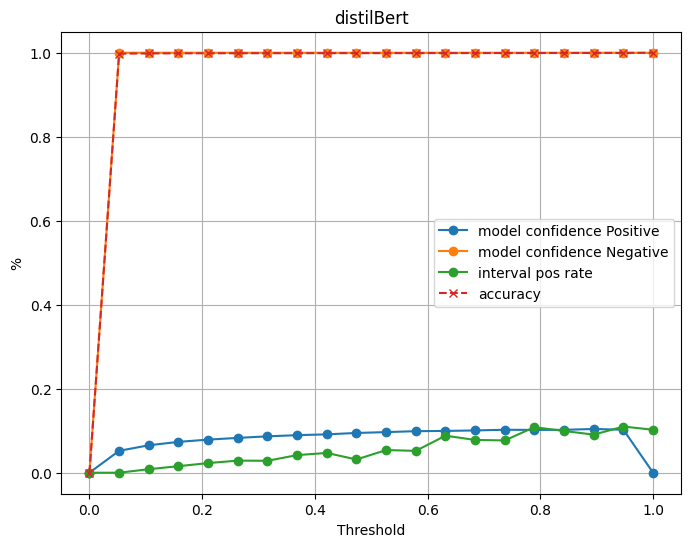

In [122]:
import matplotlib.pyplot as plt

bm25xAxis = np.linspace(0,1.0,20).tolist()
bm25truePos = []
bm25trueNeg = []
bm25Accuracy = []
for threshold in bm25xAxis:
    tp,tn,ac = measure(distilBertResult,threshold)
    bm25truePos.append(tp)
    bm25trueNeg.append(tn)
    bm25Accuracy.append(ac)
bm25IntervalPos = intervalMeasure(distilBertResult,bm25xAxis)

# Sample data
x_values = bm25xAxis  # X-axis values
y1_values = bm25truePos  # First set of Y-axis values
y2_values = bm25trueNeg  # Second set of Y-axis values
accuracy = [(y1+y2)/2 for y1,y2 in zip(y1_values,y2_values)]
print(max(accuracy))
# Create the line graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(x_values, y1_values, label='model confidence Positive', marker='o', linestyle='-')
plt.plot(x_values, y2_values, label='model confidence Negative', marker='o', linestyle='-')
plt.plot(x_values, bm25IntervalPos, label='interval pos rate', marker='o', linestyle='-')
plt.plot(x_values, bm25Accuracy, label='accuracy', marker='x', linestyle='--')

# Add labels and a legend
plt.xlabel('Threshold')
plt.ylabel('%')
plt.title('distilBert')
plt.legend()

# Show the graph (or save it to a file with plt.savefig)
plt.grid(True)  # Optional: Show grid lines
plt.show()


0.5288703855272501


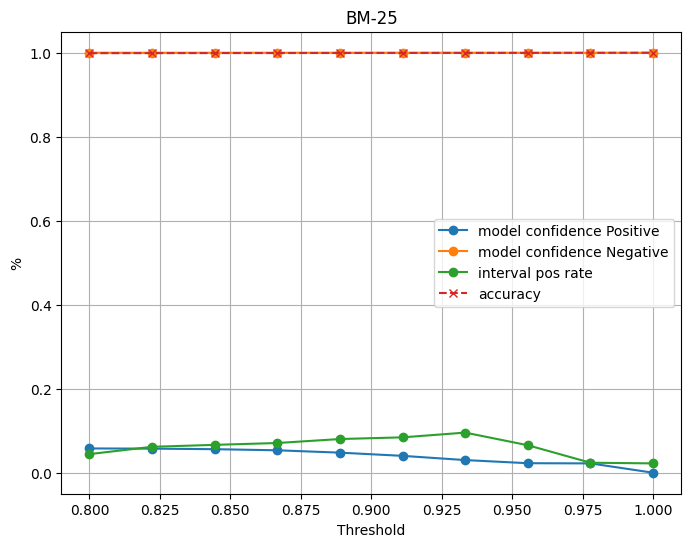

In [40]:
import matplotlib.pyplot as plt
#tiny bert
bm25xAxis = np.linspace(0.8,1.0,10).tolist()
bm25truePos = []
bm25trueNeg = []
bm25Accuracy = []
for threshold in bm25xAxis:
    tp,tn,ac = measure(bertResult,threshold)
    bm25truePos.append(tp)
    bm25trueNeg.append(tn)
    bm25Accuracy.append(ac)
bm25IntervalPos = intervalMeasure(bertResult,bm25xAxis)

# Sample data
x_values = bm25xAxis  # X-axis values
y1_values = bm25truePos  # First set of Y-axis values
y2_values = bm25trueNeg  # Second set of Y-axis values
accuracy = [(y1+y2)/2 for y1,y2 in zip(y1_values,y2_values)]
print(max(accuracy))
# Create the line graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(x_values, y1_values, label='model confidence Positive', marker='o', linestyle='-')
plt.plot(x_values, y2_values, label='model confidence Negative', marker='o', linestyle='-')
plt.plot(x_values, bm25IntervalPos, label='interval pos rate', marker='o', linestyle='-')
plt.plot(x_values, bm25Accuracy, label='accuracy', marker='x', linestyle='--')

# Add labels and a legend
plt.xlabel('Threshold')
plt.ylabel('%')
plt.title('BM-25')
plt.legend()

# Show the graph (or save it to a file with plt.savefig)
plt.grid(True)  # Optional: Show grid lines
plt.show()


In [13]:
counter = 0
for idx, r in enumerate(fullBertResult):
    if r[0] > 0.9 and r[1] == 0:
        counter += 1
        if counter == 10:

            print(idx//3000)
            print(idx%3000)
            print(r[0])
            print(idx)
            break

26
2883
0.96300495
80883


In [10]:
print(first5000[16][0])
print(first5000[883][1])


What are the good options for mobile phones under 15000?
How will the ban on 500 and 1000 rupee note stop black money?


In [ ]:
16 883

In [11]:
from sentence_transformers.cross_encoder import CrossEncoder
import numpy as np
#import os
#import csv
from sentence_transformers import InputExample
#import pickle
model = CrossEncoder('./output/training_quora-2023-09-28_16-05-03')
print(model.predict([first5000[16][0],first5000[883][1]]))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


0.96300495


In [16]:
bestAccIdx = 0
for idx,acc in enumerate(bm25Accuracy):
    if acc > bestAcc:
        bestAcc = acc
        bestAccIdx = idx
bestThresholdbm25 = bm25xAxis[bestAccIdx]


In [17]:
def binarySearch(score, confidenceList, rangeList):
	if score > rangeList[-1]:
		return confidenceList[-1]
	if score < rangeList[0]:
		return confidenceList[0]

	highIdx = len(confidenceList) - 1 
	lowIdx = 0
	while highIdx - lowIdx > 1:
		midIdx = (highIdx+lowIdx) // 2
		midScore = rangeList[midIdx]
		if score >= midScore:
			lowIdx = midIdx
		elif score < midScore:
			highIdx = midIdx

	lowScore = rangeList[lowIdx]
	highScore = rangeList[highIdx]
	if score > highScore or score < lowScore or highIdx - lowIdx > 1:
		print("ERR")
		return None
	toLowPercent = (score-lowScore) / (highScore-lowScore)
	return confidenceList[lowIdx] * toLowPercent + confidenceList[highIdx] * (1-toLowPercent)
    

In [18]:
# A: L=True   B: X=L

newResult = []
for idx in range(len(w2vResult)):
    w2vPos = binarySearch(w2vResult[idx][0],w2vIntervalPos,w2vxAxis)
    #w2vNeg = binarySearch(w2vResult[idx][0],w2vtrueNeg,w2vxAxis)
    bm25Pos = binarySearch(bm25Result[idx][0],bm25IntervalPos,bm25xAxis)
    #bm25Neg = binarySearch(bm25Result[idx][0],bm25trueNeg,bm25xAxis)
    maxPos = max(w2vPos,bm25Pos)
    #maxNeg = max(w2vNeg,bm25Neg)
    #p = maxPos / (maxPos + maxNeg)
    wtp = 0.4450466626022524
    wtn = 0.6858838108534184
    btp = 0.28199218828510747
    btn = 0.7979670428787676
    #p = w2vPos
    #if w2vResult[idx][0] < bestThreshold:
        
    #label = np.random.choice([0, 1], size=1, p=[1 - p, p])[0]

    
    
    label = 0
    if bm25Pos >= 0.5:
        label = 1
    #'''
    if w2vPos >= 0.5 and bm25Pos >= 0.5:
        label = 1
    if w2vPos < 0.5 and bm25Pos < 0.5:
        label = 0
    else:
        if bm25Pos >= 0.5:
            p = bm25Pos / (bm25Pos + (1-w2vPos))
            label = np.random.choice([0, 1], size=1, p=[1 - p, p])[0]
        else:
            p = w2vPos / (w2vPos + (1-bm25Pos))
            label = np.random.choice([0, 1], size=1, p=[1 - p, p])[0]
    #'''
        
    newResult.append((label,w2vResult[idx][1]))    

In [23]:
def combinedMeasure(result):
    counter = 0
    negCounter = 0
    totalDuplicate = 0
    totalScore = 0
    #threshold = -2 #0.1   -2
    for r in result:  #positive result have negative score
        if r[0] == 1 and r[1] == 1:
            counter += 1
        if r[0] == 0 and r[1] == 0:
            negCounter += 1
        if r[1] == 1:
            totalDuplicate += 1
        totalScore += r[0]
    return counter/totalDuplicate, negCounter/(len(result)-totalDuplicate),(counter + negCounter) / len(result)

In [33]:
#w2v only
print(combinedMeasure(newResult))

(0.4450466626022524, 0.6858838108534184, 0.5969608742866613)


In [24]:
#w2v only absolute
print(combinedMeasure(newResult))

(0.47893985783482845, 0.7907513000101961, 0.6756229267725553)


In [26]:
print(combinedMeasure(newResult))

(0.22430207084140075, 0.900630593181123, 0.6509136424240776)


In [79]:
print(combinedMeasure(newResult))

(0.42764784306894543, 0.6180283766931506, 0.5477352502467465)


In [91]:
#random
print(combinedMeasure(newResult))

(1.0, 0.0, 0.3692243377422012)


In [40]:
#bm25only
print(combinedMeasure(newResult))

(0.28199218828510747, 0.7979670428787676, 0.6074565688997949)
